## Imports

MMDetection and our library

In [1]:
import apr
import mmdet
from mmcv import Config
import pickle

c:\Users\user\anaconda3\envs\prune\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as patches
import matplotlib.lines as lines

Load the config file from MMDetection for SSD300

In [3]:
mmdetection_configs_root = 'C:/Users/user/mmdetection/configs'
original_mmdet_ssd_config = f'{mmdetection_configs_root}/ssd/ssd300_coco.py'

cfg = Config.fromfile(original_mmdet_ssd_config)

Redefine the anchors by using our `PreciseAnchorGenerator` that allows each individual anchor to be specified.

To get the scale and ratio of every anchor of an existing MMDetection model use our tool in `tools/convert_mmdet_config.py`

In [4]:
!python tools/convert_mmdet_config.py {original_mmdet_ssd_config}

Converting Anchor Generator of file C:/Users/user/mmdetection/configs/ssd/ssd300_coco.py
Converting generator of the type SSDAnchorGenerator to PreciseAnchorGenerator.
{'type': 'SSDAnchorGenerator',
 'scale_major': False,
 'input_size': 300,
 'basesize_ratio_range': (0.15, 0.9),
 'strides': [8, 16, 32, 64, 100, 300],
 'ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]]}
Old config used:
New config to be used:
{'_delete_': True,
 'type': 'PreciseAnchorGenerator',
 'strides': [8, 16, 32, 64, 100, 300],
 'scale_ratios': [[(0.07, 1.0), (0.1025, 1.0), (0.07, 0.5), (0.07, 2.0)],
                  [(0.15, 1.0),
                   (0.2225, 1.0),
                   (0.15, 0.5),
                   (0.15, 2.0),
                   (0.15, 0.3333),
                   (0.15, 3.0)],
                  [(0.33, 1.0),
                   (0.4102, 1.0),
                   (0.33, 0.5),
                   (0.33, 2.0),
                   (0.33, 0.3333),
                   (0.33, 3.0)],
                  [(0.51, 

*The adjusted model config below is **not** compatible with the provided model checkpoint from MMDetection, the difference is in the order of anchors, we specify them in the same order as the original SSD paper which is different to the order of the MMDetection model.*

In [5]:
adjusted_model_cfg = dict(
    model=dict(
        bbox_head=dict(
            anchor_generator=dict(
                _delete_=True,
                type='PreciseAnchorGenerator',
                strides=[8, 16, 32, 64, 100, 300],
                scale_ratios=(
                    ((0.07, 1.0), (0.07, 2.0), (0.07, 0.5), (0.1024, 1.0)),
                    ((0.15, 1.0), (0.15, 2.0), (0.15, 3.0), (0.15, 0.5), (0.15, 1 / 3), (0.224, 1.0)),
                    ((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), (0.33, 0.5), (0.33, 1 / 3), (0.4102, 1.0)),
                    ((0.51, 1.0), (0.51, 2.0), (0.51, 3.0), (0.51, 0.5), (0.51, 1 / 3), (0.5932, 1.0)),
                    ((0.69, 1.0), (0.69, 2.0), (0.69, 0.5), (0.7747, 1.0)),
                    ((0.87, 1.0), (0.87, 2.0), (0.87, 0.5), (0.9557, 1.0)),
                    ),
                anchor_base_size=300,
                centers=((4, 4), (8, 8), (16, 16), (32, 32), (50, 50), (150, 150))
            )
        )
    )
)
cfg.merge_from_dict(adjusted_model_cfg)

The required input for our anchor pruning script is a directory with a checkpoint of the model named `best_checkpoint.pth` and a single `.py` config file. So lets create that:

In [7]:
#! mkdir pruning_directory
# Download ssd_baseline.pth from https://cloud.ilabt.imec.be/index.php/s/ERxYsRMidPEgNwT
#! cp ssd_baseline.pth ./pruning_directory/best_checkpoint.pth
#! cp ./configs/ssd_baseline.py ./pruning_directory/ 

And then run our tool:

In [6]:
!python tools/prune_anchors.py -i ./pruning_directory/ -o ./pruning_directory/pruning_results.pickle

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
load checkpoint from local path: pruning_directory\best_checkpoint.pth
INFO:root:Processing {}

Evaluating bbox...
Loading and preparing results...
DONE (t=0.44s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.24s).
Accumulating evaluation results...
DONE (t=4.77s).

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.316
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.253
 Average Recall     (AR

c:\users\user\mmdetection\mmdet\models\dense_heads\anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
c:\users\user\mmdetection\mmdet\core\anchor\anchor_generator.py:333: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
c:\users\user\mmdetection\mmdet\core\anchor\anchor_generator.py:369: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(
c:\Users\user\anaconda3\envs\prune\lib\site-packages\torchprofile\profile.py:22: UserWarning: No handlers found: "aten::empty". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
c:\users\user\mmdetection\mmdet\core\anchor\anchor_generator.py:333: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_prior

In [7]:
with open('./pruning_directory/pruning_results.pickle', 'rb') as map_results_file:
    results = pickle.load(map_results_file)
results['pareto_front'] = list(reversed(sorted(results['pareto_front'], key=lambda k: k['mAP']))) # sort pareto front on mAP

`results` is a dictionary that consists of a list of the pareto front of anchor configurations that are optimal to prune.
Based on the mAP and the #mac operation one can choose which pruned configuration one would like to use.
Below we plot the pareto frontier of pruned configurations.

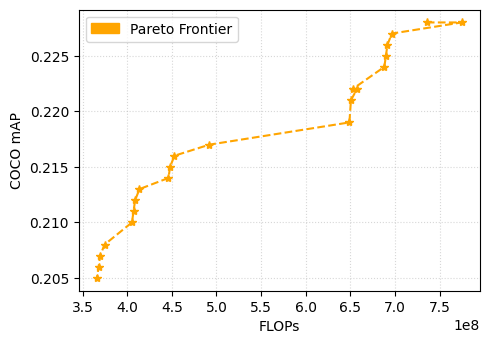

In [8]:
fig = plt.figure(1, figsize=(5,3.54331))
ax = plt.subplot(111)
ax.set_xlabel('FLOPs')
ax.set_ylabel('COCO mAP')

ax.plot([node['macs'] for node in results['pareto_front']], [node['mAP'] for node in results['pareto_front']],
       linestyle='--', marker='*', color='orange', markerfacecolor='orange', markersize=6)
legend_patches =  [patches.Patch(color='orange', label='Pareto Frontier')]
ax.set_xlabel('FLOPs')
ax.set_ylabel('COCO mAP')
ax.grid(linestyle=':', alpha=0.5)
plt.legend(handles=legend_patches)
plt.tight_layout()
plt.show()

In [9]:
for node in results['pareto_front']:
    print(node['removed_anchors'], node['mAP'], node['macs'])

{2} 0.228 735770880
set() 0.228 774938880
{2, 3} 0.227 696602880
{2, 3, 7} 0.226 691706880
{9, 2, 3, 7} 0.225 689944320
{2, 3, 7, 9, 10} 0.224 688181760
{2, 3, 5, 7} 0.222 652538880
{2, 3, 5} 0.222 657434880
{2, 3, 5, 7, 9} 0.221 650776320
{2, 3, 5, 7, 9, 10} 0.219 649013760
{1} 0.217 492145920
{1, 3} 0.216 452977920
{1, 3, 7} 0.215 448081920
{1, 3, 9, 7} 0.214 446319360
{1, 3, 6} 0.213 413809920
{1, 3, 6, 7} 0.212 408913920
{1, 3, 6, 7, 9} 0.211 407151360
{1, 3, 6, 7, 9, 10} 0.21 405388800
{1, 3, 5, 6} 0.208 374641920
{1, 3, 5, 6, 7} 0.207 369745920
{1, 3, 5, 6, 7, 9} 0.206 367983360
{1, 3, 5, 6, 7, 9, 10} 0.205 366220800


To convert these `removed_anchors` back to a configuration you remove the anchors corresponding to the indices indicated above.
For example Configuration A from the paper corresponds with the pruned configuration with the highest accuracy and becomes:

configuration A = {5, 7, 13, 16, 17, 19, 22, 25, 26, 27, 28})

scale_ratios=(

((0.07, 1.0), (0.07, 2.0), (0.07, 0.5), (0.1024, 1.0)),

((0.15, 1.0), ~~(0.15, 2.0)~~, (0.15, 3.0), ~~(0.15, 0.5)~~, (0.15, 1 / 3), (0.224, 1.0)),

((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), ~~(0.33, 0.5)~~, (0.33, 1 / 3), (0.4102, 1.0)),

(~~(0.51, 1.0), (0.51, 2.0)~~, (0.51, 3.0), ~~(0.51, 0.5)~~, (0.51, 1 / 3), (0.5932, 1.0)),

(~~(0.69, 1.0)~~, (0.69, 2.0), (0.69, 0.5), ~~(0.7747, 1.0)~~),

(~~(0.87, 1.0), (0.87, 2.0), (0.87, 0.5),~~ (0.9557, 1.0)),
),

In [ ]:
adjusted_model_cfg = dict(
    model=dict(
        bbox_head=dict(
            anchor_generator=dict(
                _delete_=True,
                type='PreciseAnchorGenerator',
                strides=[8, 16, 32, 64, 100, 300],
                scale_ratios=(
                    ((0.07, 1.0), (0.07, 2.0), (0.07, 0.5), (0.1024, 1.0)),
                    ((0.15, 1.0), (0.15, 3.0), (0.15, 1/3), (0.224, 1.0)),
                    ((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), (0.33, 1/3), (0.4102, 1.0)),
                    ((0.51, 3.0), (0.51, 1/3), (0.5932, 1.0)),
                    ((0.69, 2.0), (0.69, 0.5)),
                    ((0.9557, 1.0))
                    ),
                anchor_base_size=300,
                centers=((4, 4), (8, 8), (16, 16), (32, 32), (50, 50), (150, 150))
            )
        )
    )
)
cfg.merge_from_dict(adjusted_model_cfg)

To train these new configurations with MMDetection it is as simple as adding `import apr` to the scripts of MMDetection. Or you can use the scripts provided in our tools directory, which have done exactly that.